In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from datasets import load_dataset
emotions = load_dataset ("go_emotions", "simplified")
depression = load_dataset("ShreyaR/DepressionDetection")
emotions.set_format(type="pandas")
depression.set_format(type="pandas")
df1 = emotions["train"][:]
df2 = depression["train"][:]
df1.drop(columns=['id'], inplace=True) #dropping irrelevant coloums, and also some emotions as this dataset has far too many
df1['labels'] = df1['labels'].apply(lambda x: x[0])
df2.rename(columns={'is_depression': 'depression', "clean_text": "text"}, inplace=True)
df2 = df2[df2['depression'] != 0] #removing all rows where depression is 0 as all other emotions data is missing
merged_df = pd.concat([df1, df2], ignore_index=True)
merged_df = merged_df.fillna(0)
merged_df.loc[merged_df['depression'] == 1, 'labels'] = 28
merged_df.drop(columns=['depression'], inplace=True) #dropping depression column as its now duplicate data
merged_df.rename(columns={'labels': 'label'}, inplace=True)
merged_df['label'] = merged_df['label'].astype('int64')
#half_sample = merged_df.sample(frac=0.01, random_state=42)
#merged_df = half_sample
merged_df.head()

,text,label
0,My favourite food is anything I didn't have to...,27
1,"Now if he does off himself, everyone will thin...",27
2,WHY THE FUCK IS BAYLESS ISOING,2
3,To make her feel threatened,14
4,Dirty Southern Wankers,3


<Axes: ylabel='Frequency'>

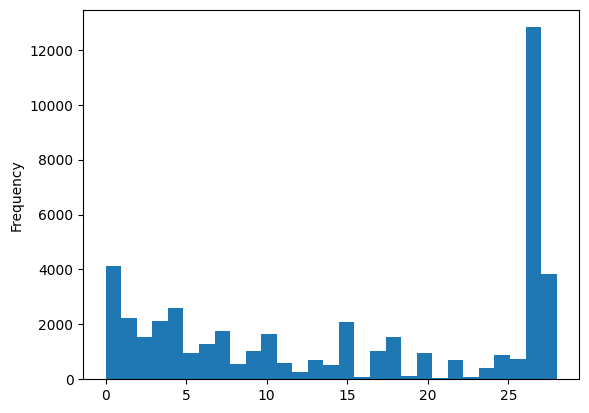

In [3]:
merged_df["label"].plot(kind="hist", bins=29) 

It's quite clear that the dataset is populated with a large array of different emotions. The nuetral frequency however is much higher. Training the model on this dataset is returning a model with around 50-60% accuracy. I believe this may be because there are too many labels. NLP models can often struggle distinguishing similar emotions as a piece of text may often have multiple emotions in differing quantities, removing the number of emotions should improve the models ability to classify text correctly. I want to retain depression and anxiety as identifying them is the goal of the project, as well as this I've decided to retain some emotions which are very differnet to these two as the model should not get confused on them and it will provide more varied training data.

In [4]:
merged_df.shape

(47241, 2)

The emotions i'm keeping:  
2 = anger  
17 = joy  
19 = nervousness   
25 = sadness  
27 = nuetral  
28 = depression   

In [5]:
merged_df = merged_df[merged_df['label'].isin([2, 17, 19, 25, 27, 28])]
merged_df.shape

(20193, 2)

After narrowing down the number of labels accuracy has shot up to 90%. This hasn't sovled the imbalce issue of nuetral far outnumbering the other labels and I am concerned that the model may only be good at classifying the nuetral label and since it far outnumbers the others its skewing the accuracy data to be higher. I Decided to find more data to add to the dataset and came accross a dataset which is comprised of labelled twitter messages into 6 different emotions. Three of the included emotions were anger, joy and sadness. This diversity of data should help increase the models generalisation and prevent overfitting.

In [6]:
from datasets import load_dataset
moreemotions= load_dataset("dair-ai/emotion", "split")
moreemotions.set_format(type="pandas")
df3 = moreemotions["train"][:]
df3.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [7]:
df3.shape

(16000, 2)

In [8]:
df3 = df3.drop(df3[df3['label'].isin([2, 4, 5])].index)
df3['label'] = df3['label'].replace({0: 25, 3: 2, 1: 17})
df3.head

<bound method NDFrame.head of                                                     text  label
0                                i didnt feel humiliated     25
1      i can go from feeling so hopeless to so damned...     25
2       im grabbing a minute to post i feel greedy wrong      2
4                                   i am feeling grouchy      2
5      ive been feeling a little burdened lately wasn...     25
...                                                  ...    ...
15995  i just had a very brief time in the beanbag an...     25
15996  i am now turning and i feel pathetic that i am...     25
15997                     i feel strong and good overall     17
15998  i feel like this was such a rude comment and i...      2
15999  i know a lot but i feel so stupid because i ca...     25

[12187 rows x 2 columns]>

In [9]:
df3.shape

(12187, 2)

In [10]:
merged_df.head()

,text,label
0,My favourite food is anything I didn't have to...,27
1,"Now if he does off himself, everyone will thin...",27
2,WHY THE FUCK IS BAYLESS ISOING,2
9,It might be linked to the trust factor of your...,27
12,Hello everyone. Im from Toronto as well. Can c...,27


In [11]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20193 entries, 0 to 47240
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20193 non-null  object
 1   label   20193 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 473.3+ KB


In [12]:
merged_df.shape

(20193, 2)

In [13]:
merged_df = pd.concat([merged_df, df3], ignore_index=True)
merged_df.to_csv('combined_data.csv', index=False)
merged_df.shape

(32380, 2)

In [14]:
from sklearn.model_selection import train_test_split

train_df, test_valid_df = train_test_split(merged_df, test_size=0.2, random_state=42) #creating test train splits
test_df, valid_df = train_test_split(test_valid_df, test_size=0.5, random_state=42)

from datasets import DatasetDict
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df)
valid_dataset = Dataset.from_pandas(valid_df)   #converting dataframes to datasets
test_dataset = Dataset.from_pandas(test_df)
ds_splits = DatasetDict({                       #and then combing to a dataset dict
    'train': train_dataset,
    'validation': valid_dataset,
    'test': test_dataset
})
ds_splits

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 25904
    })
    validation: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 3238
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 3238
    })
})

In [15]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenizer_function(batch):
    return tokenizer(batch["text"], padding= True, truncation= True)

In [16]:
tokenized_data= ds_splits.map(tokenizer_function,
                             batched= True,
                             batch_size= 16)

Map:   0%|          | 0/25904 [00:00<?, ? examples/s]

Map:   0%|          | 0/3238 [00:00<?, ? examples/s]

Map:   0%|          | 0/3238 [00:00<?, ? examples/s]

In [17]:
print(tokenized_data.column_names)

{'train': ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'], 'validation': ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'], 'test': ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask']}


In [18]:
from transformers import AutoModelForSequenceClassification
import torch
checkpoint = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if(torch.cuda.is_available()):
    print("GPU Found, model will train on GPU!")
else:
    print("No GPU found. CPU will be used to train model, this will take significanly longeer (In my case GPU sped up training by 100X)")

torch.cuda.empty_cache()
model = (AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = 6).to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPU Found, model will train on GPU!


In [19]:
# from huggingface_hub import notebook_login
# notebook_login()

In [20]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds=pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc =accuracy_score(labels, preds)
    return {"accureacy": acc, "f1": f1}

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir= "final-tuneed-project-model",
    num_train_epochs= 10,
    learning_rate= 2e-5,
    per_device_train_batch_size=20,
    per_device_eval_batch_size=20,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    push_to_hub=True
)

from transformers import Trainer

trainer = Trainer(
    model = model,
    args = training_args,
    compute_metrics= compute_metrics,
    train_dataset= tokenized_data["train"],
    eval_dataset= tokenized_data["validation"],
    tokenizer= tokenizer
)

trainer.train()
torch.cuda.empty_cache()

/home/keith/.local/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/12960 [00:00<?, ?it/s]

: 